# An Implementation of the Discrete Information Bottleneck Algorithm

### Peter A. Foster
Introduced by Tishby et al. [1], the Information Bottleneck (IB) is a mathematical framework for a variety of probabilistic approaches which aim at obtaining a representation of an 'input' random variable $X$, in relation to an 'output' random variable $Y$. This representation of $X$ is in terms of the intermediate random variable $T$, the latter which aims at being maximally informative about $Y$, while being minimally informative about $X$. In this way, the IB may be viewed as a method for constructing a lossy encoding of input $X$, such that only the essential structure in $X$ is preserved with a view to predicting output $Y$.

More formally, informativeness is quantified in terms of mutual information [2]. For discrete random variables $X$, $Y$ governed by the joint probability mass function $P_{XY}$, the mutual information I(X; Y) is defined as
$$ I(X; Y) = \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} \log P_{XY}(x, y) \frac{P_{XY}(x, y)}{P_X(x) P_Y(y)}$$
where $\mathcal{X}$, $\mathcal{Y}$ respectively denote the sample spaces of $X$, $Y$. Furthermore, $P_X$, $P_Y$ respectively correspond to the marginal distributions of $X$ and $Y$. Taking logarithms to the base 2, mutual information is quantified in bits.

In the IB, we seek to minimise the loss functional $\mathcal{L}[Q_{T|X}]$, defined in terms of mutual information as
$$\mathcal{L}[Q_{T|X}] = I(X;T) - \beta I(T;Y)$$
where $Q_{T|X}$ corresponds to the probability distribution of $T$ conditioned of $X$. We may consider $Q_{T|X}$ a (stochastic) encoding function which we apply to our input $X$. Hyper-parameter $\beta$ governs the trade-off between lossiness of the encoding function $Q_{T|X}$ (in relation to the input $X$) versus its ability to predict (in relation to the output $Y$). Whereas small $\beta$ values place greater emphasis on encoding lossiness, large $\beta$ values place greater emphasis on predictive ability.

Furthermore, random variable $T$ is subject to the Markov chain $T \rightarrow X \rightarrow Y$; it is assumed that
$$ P(T, X, Y) = P(T) P(X|T) P(Y|X) = P(X, T) P(Y|X) = P(X) P(T|X) P(Y|X)$$
from which it follows that
$$P(T, Y|X) = P(T,X,Y)/P(X) = P(T|X)P(Y|X)$$
which implies that $T$ and $Y$ are conditionally independent. Because of this conditional independence, we may consider $T$ an encoding of $X$ alone. Moreover, because it is not assumed that the joint distribution $P(X,Y)$ factorises, $T$ is not a latent variable of the observed data. As formulated, we may therefore consider the IB a 'model-agnostic' approach, because it makes no assumptions about $P(X, Y)$. Rather, the IB operates on the basis of *a priori* knowledge (or some estimate) of $P(X, Y)$.

## The Discrete Information Bottleneck
The IB has been applied to high-dimensional discrete-valued data (such as text, for the purpose of clustering [3] or sentiment analysis [4]), continuous-valued data (such as image data, for the purpose of automatic segmentation [5]), as well as serving as a formalism for analysing the behaviour of deep learning models [6]. It is also worth mentioning that there are generatisations of the loss functional presented above [7]. This notebook deals with the iterative algorithm introduced by Tishby et al. [1], which bears similarity to the Blahut-Arimoto algorithm in rate distortion theory [8] and which is guaranteed to converge to a local optimum of the IB functional. The algorithm is reproduced from Strouse and Schwab [7]:

1. Given $P_{X, Y}$, $\beta \geq 0$, number of codewords $K$
2. Initialise $Q^0_{T|X}$ and set $n=0$
3. $Q^0_T(t) = \sum_x P_X(x) Q^0_{T|X}(t, x)$
4. $Q^0_{Y|T}(y, t) = \frac{1}{Q^0_T(t)} \sum_x P_{XY}(x, y) Q^0_{T|X}(t, x)$
5. **while** not converged **do**
    1. $n = n + 1$
    2. $D^{n-1}(x, t) = D_{\text{KL}}[P_{Y|X}(y, x) \| Q^{n-1}_{Y|T}(y, t)]$
    3. $Q^n_{T|X}(t, x) = \frac{Q^{n-1}_{T}(t)}{Z(x, \beta)}\exp[-\beta D^{n-1}(x, t)]$
    4. $Q^n_T(t) = \sum_x P_X(x) Q^n_{T|X}(t, x)$
    5. $Q^n_{Y|T}(y, t) = \frac{1}{Q^n_{T}(t)} \sum_x Q^n_{T|X}(t, x) P_{X|Y}(x, y)$
6. **end while**

In the above pseudo-code, $Q^n_{T|X}$ is the encoding table at time step $n$, providing a probabilistic (i.e. soft) codeword assignment to each of $K$ distinct codewords (i.e. possible outcomes of $T$), given each possible outcome of $X$. Conversely, $Q^n_{Y|T}$ is the analogous decoding table at time step $n$, which assigns probabilities of outcomes of $Y$, given each possible codeword outcome of $T$. After initialisation, the algorithm iterates until convergence, computing the Kullback-Leibler (KL) divergence [2] $D_{\text{KL}}[P_{Y|X} \| Q^{n-1}_{Y|T}]$ between distributions $P_{Y|X}$, $Q^{n-1}_{Y|T}$ as an itermediate step. Following convention, the quantity $Z(x, \beta)$ is responsible for ensuring that $Q^n_{T|X}$ is a correctly normalised probability distribution.

### Applications of the Discrete Information Bottleneck in Machine Learning
Beyond source coding applications, the assignment of codewords to input variable $X$ based on output variable $Y$ suggests that the above algorithm may be readily applied for supervised learning tasks. One such supervised learning task is document classification: In this setting, the input random variable $X$ might correspond to a 'bag of words' (representing document identity), whereas the output random variable $Y$ might correspond to a topic label. By examining the encoding distribution $Q_{T|X}$ we then might attempt to identify clusters of words for predicting the topic label [9]. In such a setting, we would expect hyper-parameter $\beta$ to have the effect of a regularisation parameter for selected features: Whereas we would expect large values of $\beta$ to promote fine-grained clusterings, small values would be expected to promote coarse-grained clusterings. As an analogous unsupervised learning task, the input random variable $X$ might again correspond to a document, whereas the output random variable might correspond to an individual word occuring in the document. Such an unsupervised learning task would aim at identifying clusters of documents with similar word statistics [9].


## Scope of this Notebook
This notebook implements a prototype version of the above IB algorithm and evaluates its behavior, based on toy examples and synthetic data. The notebook aims at demonstrating the algorithm's correct behaviour, assuming *a priori* knowledge of the joint distibution $P(X, Y)$. Evaluation of the IB algorithm against real-world data, for the purpose of feature selection, clustering or classification, or in combination with a method for estimating the joint distribition $P(X, Y)$ is left for a subsequent exercise.

## References
[1] N. Tishby, F. C. Pereira, and W. Bialek. The information bottleneck method. In: Proceedings of the 37th Allerton Conference on Communication, Control, and Computing, 1999.

[2] T. M. Cover and J. A. Thomas. Elements of information theory. John Wiley & Sons, 2012.

[3] L.D. Baker and A.K. McCallum. Distributional clustering of words for text classification. In: Proceedings of SIGIR, 1998.

[4] W. Du, S. Tan, X. Cheng, and X. Yun. Adapting information bottleneck method for automatic construction of domain-oriented sentiment lexicon. In: Proceedings of the third ACM international conference on Web search and data mining, 2010.

[5] A. Bardera, J. Rigau, I. Boada, M. Feixas, and M. Sbert. "Image segmentation using information bottleneck method." IEEE Transactions on Image Processing 18, no. 7 (2009): pp. 1601-1612.

[6] N. Tishby, and N. Zaslavsky. Deep learning and the information bottleneck principle. In: Proceedings of the IEEE Information Theory Workshop (ITW), 2015.

[7] D.J. Strouse, and D. J. Schwab. "The deterministic information bottleneck." Neural Computation 29, no. 6 (2017): pp. 1611-1630.

[8] S. Arimoto. "An algorithm for computing the capacity of arbitrary discrete memoryless channels." IEEE Transactions on Information Theory 18, no. 1 (1972): pp. 14-20.

[9] O. Shamir, S. Sabato, and N. Tishby. "Learning and generalization with the information bottleneck." Theoretical Computer Science 411, no. 29-30 (2010): pp. 2696-2711.

In [69]:
import collections
import itertools
import pdb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pyitlib import discrete_random_variable as drv
import scipy.stats

%matplotlib inline

# Algorithm Implementation
Implement an IB algorithm class based on the above pseudo-code. Since this implementation represents a prototype, we use assertions to help establish correctness.

The implementation allows the hyperparameter $\beta$ and the number of codewords $K = |\mathcal{T}|$ to be specified on object construction. In addition, we implement a 'diagnostic mode' which stores a list of the states of the encoding and decoding tables $Q^{n}_{T|X}$, $Q^{n}_{Y|T}$ across iterations.

To initialise $Q^{0}_{T|X}$, we assign uniformly distributed random variates, before ensuring correct normalisation.

As our convergence statistic, we use the maximum of the relative absolute deviation of the entries in the updated encoding table $Q^n_{T|X}$ at iteration $n$, $$\text{convergence_stat} = \max_{t \in \mathcal{T}, x \in \mathcal{X}} \frac{\left| Q^n_{T|X}(t, x) - Q^{n-1}_{T|X}(t, x) \right|}{Q^{n-1}_{T|X}(t, x)},$$
terminating when $\text{convergence_stat}$ falls below a user-specified tolerance value.

In [3]:
class IBEstimator():
    # For convenience, create a named tuple to refer to 3D array axes by random variable names
    # Consistent axis/variable assignment facilitates broadcasting
    AXES = collections.namedtuple('Axes', 'x t y')(0, 1, 2)
    
    P_EPS = np.spacing(0)
    
    def __init__(self, beta=0.5, n_clusters=None, relative_tolerance=1E-04, min_iterations=0,
                 diagnostic_mode=True):
        self.beta = beta
        self.n_clusters = n_clusters
        self.relative_tolerance = relative_tolerance
        self.min_iterations = min_iterations
        self.diagnostic_mode = diagnostic_mode
        
    def train(self, p_xy_joint):
        p_xy_joint, p_x, p_yx_conditional, q_t = self._initialise_probability_tables(p_xy_joint)
        self._initialise_convergence_diagnostics()
        self._iterate_until_convergence(p_xy_joint, p_x, p_yx_conditional, q_t)
        
        self.q_tx_conditional = np.squeeze(self.q_tx_conditional)
        self.q_yt_conditional = np.squeeze(self.q_yt_conditional)
        
    def _initialise_probability_tables(self, p_xy_joint):
        x_sample_space_cardinality = p_xy_joint.shape[0]

        if self.n_clusters is None:
            t_sample_space_cardinality = p_xy_joint.shape[0]
        else:
            t_sample_space_cardinality = self.n_clusters
        
        # Add small value to joint distribution to account for edge cases
        p_xy_joint += IBEstimator.P_EPS
        # Expand to 3D array
        p_xy_joint = np.expand_dims(p_xy_joint, IBEstimator.AXES.t)
        assert(np.isclose(np.sum(p_xy_joint), 1))
        
        p_x = np.sum(p_xy_joint, axis=IBEstimator.AXES.y, keepdims=True)
        
        p_yx_conditional = p_xy_joint / p_x
        
        # Initialise the encoding table
        self.q_tx_conditional = np.random.uniform(size=(x_sample_space_cardinality,
                                                        t_sample_space_cardinality, 1))
        self.q_tx_conditional /= np.sum(self.q_tx_conditional, axis=IBEstimator.AXES.t, keepdims=True)
        assert(np.allclose(np.sum(self.q_tx_conditional, axis=IBEstimator.AXES.t), 1))
        
        q_t = np.sum(p_x * self.q_tx_conditional, axis=IBEstimator.AXES.x, keepdims=True)
        assert(np.isclose(np.sum(q_t), 1))
        
        self.q_yt_conditional = np.sum(p_xy_joint * self.q_tx_conditional, axis=IBEstimator.AXES.x,
                                       keepdims=True) / q_t       
        assert(np.allclose(np.sum(self.q_yt_conditional, axis=IBEstimator.AXES.y), 1))

        return p_xy_joint, p_x, p_yx_conditional, q_t
    
    def _initialise_convergence_diagnostics(self):        
        self.convergence_stat_all = []
        self.q_tx_conditional_all = []
        self.q_yt_conditional_all = []
        
    def _update_convergence_diagnostics(self, convergence_stat):
        self.convergence_stat_all.append(convergence_stat)
        self.q_tx_conditional_all.append(np.squeeze(self.q_tx_conditional))
        self.q_yt_conditional_all.append(np.squeeze(self.q_yt_conditional))        
        
    def _iterate_until_convergence(self, p_xy_joint, p_x, p_yx_conditional, q_t):
        is_converged = False

        if self.diagnostic_mode:
            self._update_convergence_diagnostics(convergence_stat=None)

        i = 0
        while not is_converged or i < self.min_iterations:
            kl_divergence = IBEstimator._kl_divergence(p_yx_conditional, self.q_yt_conditional,
                                                       axis_to_sum_over=IBEstimator.AXES.y)
            q_tx_conditional_new = q_t * np.exp(-1 * self.beta * kl_divergence)
            q_tx_conditional_new /= np.sum(q_tx_conditional_new, axis=IBEstimator.AXES.t, keepdims=True)
            assert(np.allclose(np.sum(q_tx_conditional_new, axis=IBEstimator.AXES.t), 1))
            
            q_t = np.sum(p_x * q_tx_conditional_new, axis=IBEstimator.AXES.x, keepdims=True)
            assert(np.allclose(np.sum(q_t, axis=IBEstimator.AXES.t), 1))
            
            self.q_yt_conditional = np.sum(q_tx_conditional_new * p_xy_joint, axis=IBEstimator.AXES.x,
                                           keepdims=True) / q_t
            assert(np.allclose(np.sum(self.q_yt_conditional, axis=IBEstimator.AXES.y), 1))
            
            # Test for convergence
            convergence_stat = np.max(np.abs((q_tx_conditional_new - self.q_tx_conditional) /
                                                  (self.q_tx_conditional + IBEstimator.P_EPS)))
            if convergence_stat < self.relative_tolerance:
                is_converged = True
            
            self.q_tx_conditional = q_tx_conditional_new
            
            if self.diagnostic_mode:
                self._update_convergence_diagnostics(convergence_stat)
                
            i += 1
            
    @staticmethod
    def _kl_divergence(p, q, axis_to_sum_over):
        return -1 * np.sum(p * (np.log(q + IBEstimator.P_EPS) - np.log(p + IBEstimator.P_EPS)),
                           axis=axis_to_sum_over, keepdims=True)

# Experiment Set  I)
We first consider the trivial joint distribution $P_{X, Y}$ which defines a bijection on equi-probable binary outcomes of $X$,
$$ P_{XY}(x, y) = \begin{bmatrix} 0.5 & 0 \\ 0 & 0.5 \end{bmatrix}_{x, y}$$
where $\mathcal{X} = \mathcal{Y} = \left\{1, 2 \right\}$.
## Manual Inspection of Encoding Table vs. Convergence Statistic
A basic check involves manually inspecting the encoding table $Q_{T|X}^n$ versus the convergence statistic at iteration $n$, for various values of $\beta$:

In [4]:
def evaluate_encoding_matrix_updates(p_xy_joint, beta_values, **kwargs):
    for beta in beta_values:
        ib = IBEstimator(beta=beta, **kwargs)
        print('---------Training with parameters beta={}, additional args={}---------'.format(beta, kwargs))
        ib.train(p_xy_joint)
        
        for i, (q_tx_conditional, convergence_stat) in enumerate(zip(ib.q_tx_conditional_all,
                                                                     ib.convergence_stat_all)):
            if i==0:
                print('Initial state:')
            else:
                print('State after iteration {} (convergence stat. is {}):'.format(i, convergence_stat))
            
            print(q_tx_conditional)

In [5]:
p_xy_joint = np.array(((0.5, 0.0),
                       (0.0, 0.5)))
np.random.seed(0)
evaluate_encoding_matrix_updates(p_xy_joint, beta_values=(0, 0.1, 1, 10, 100))

---------Training with parameters beta=0, additional args={}---------
Initial state:
[[0.43418691 0.56581309]
 [0.52521691 0.47478309]]
State after iteration 1 (convergence stat. is 0.104828118491):
[[0.47970191 0.52029809]
 [0.47970191 0.52029809]]
State after iteration 2 (convergence stat. is 0.0):
[[0.47970191 0.52029809]
 [0.47970191 0.52029809]]
---------Training with parameters beta=0.1, additional args={}---------
Initial state:
[[0.39610605 0.60389395]
 [0.32917129 0.67082871]]
State after iteration 1 (convergence stat. is 0.0913004936771):
[[0.36593205 0.63406795]
 [0.35922479 0.64077521]]
State after iteration 2 (convergence stat. is 0.00840047396769):
[[0.36291319 0.63708681]
 [0.36224245 0.63775755]]
State after iteration 3 (convergence stat. is 0.000833217976338):
[[0.36261135 0.63738865]
 [0.36254427 0.63745573]]
State after iteration 4 (convergence stat. is 8.32539434156e-05):
[[0.36258116 0.63741884]
 [0.36257446 0.63742554]]
---------Training with parameters beta=1, ad

### Key observations:
1) The encoding table $Q_{T|X}$ appears to converge after a few iterations, with the convigence statistic matching observed relative changes in conditional probability. We observe no unexpected convergence test behaviour.

2) For relatively large values of $\beta$, the resultant $Q_{T|X}$ after convergence is a bijection. Since the term $I(T;Y)$ dominates for large $\beta$, the observed result is consistent with correct operation: with $X$ and $Y$ perfectly correlated, $Q_{T|X}$ retains maximal information about $Y$.

3) Conversely, for relatively small values of $\beta$, the result after convergence is $Q_{T|X} \approx P_T$, implying independence. Since the term $I(X;T)$ dominates for small values of $\beta$, this result is also consistent with correct operation: $T$ is minimally informative about $X$.

4) Minor observation: The observed number of iterations before convergence varies between 1 and 5

5) Minor observation: Our convergence statistic does not always decrease monotonically

6) Minor observation: For $\beta=1$, $Q_{T|X}$ after convergence is equivalent to the initial state $Q^1_{T|X}$. With $X$ and $Y$ perfectly correlated, we have $I(X;T) = I(T;Y)$ for all $Q_{T|X}$. It follows that our optimisation criterion is minimal for all $Q_{T|X}$, which is consistent with the observed behaviour.

## Analysis of Optimisation Criterion Behaviour
To further help establish that the optimisation criterion $I(X;T)- \beta I(T;Y)$ is minimised when executing our IB implementation, we next consider a larger, finer-grained set of values for $\beta$ and plot the evolution of $I(X;T) - \beta I(T;Y)$. Moreover, we explore the effect of random initialisation, by executing 100 runs of the IB algorithm, for each considered value of $\beta$. As above, the analysis is based on the trivial joint distribution $P_{XY}$,
$$ P_{XY}(x, y) = \begin{bmatrix} 0.5 & 0 \\ 0 & 0.5 \end{bmatrix}_{x, y}$$

In [6]:
def compute_mutual_information_terms(p_xy_joint, q_tx_conditional, q_yt_conditional):
    q_xt_joint = q_tx_conditional * np.sum(p_xy_joint, axis=1, keepdims=True)
    assert(np.isclose(np.sum(q_xt_joint), 1))
    
    q_ty_joint = q_yt_conditional * np.sum(q_xt_joint, axis=0, keepdims=True).T
    assert(np.isclose(np.sum(q_ty_joint), 1))
    
    q_x = np.sum(q_xt_joint, axis=1)
    assert(np.isclose(np.sum(q_x), 1))
    
    q_y = np.sum(q_ty_joint, axis=0)
    assert(np.isclose(np.sum(q_y), 1))
    
    q_t = np.sum(q_xt_joint, axis=0)
    assert(np.isclose(np.sum(q_t), 1))
        
    mutual_information_xt = drv.entropy_pmf(q_t) + drv.entropy_pmf(q_x) - drv.entropy_pmf(np.ravel(q_xt_joint))
    mutual_information_ty = drv.entropy_pmf(q_y) + drv.entropy_pmf(q_t) - drv.entropy_pmf(np.ravel(q_ty_joint))
    
    return mutual_information_xt, mutual_information_ty

def evaluate_convergence(p_xy_joint, beta_values, n_runs=100, **kwargs):
    opt_criterion_all = {}

    for beta in beta_values:
        opt_criterion_all[beta] = []
        for i in range(n_runs):
            ib = IBEstimator(beta=beta, **kwargs)
            ib.train(p_xy_joint)
        
            mi_terms = [compute_mutual_information_terms(p_xy_joint, q_tx_cond, q_yt_cond)
                        for q_tx_cond, q_yt_cond in zip(ib.q_tx_conditional_all, ib.q_yt_conditional_all)]
            mutual_information_xt, mutual_information_ty = zip(*mi_terms)
            opt_criterion_all[beta].append(pd.Series(mutual_information_xt) - 
                                           beta * pd.Series(mutual_information_ty))

    fig, axes = plt.subplots(nrows=len(beta_values), ncols=2, figsize=(14,50), sharey='row')
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    for beta, ax in zip(beta_values, axes):
        opt_criterion_all[beta] = pd.DataFrame(opt_criterion_all[beta]).T
        # Ensure that data can be log-transformed
        opt_criterion_all[beta] -= opt_criterion_all[beta].min().min() - 1E-10
        
        opt_criterion_all[beta].plot(logx=False, logy=True, ax=ax[0],
                                     title=('Optimisation criterion [I(X;T) - beta*I(T;Y)] '
                                            'vs. number of iterations for beta={}'.format(beta)))
        ax[0].get_legend().remove()
        ax[0].set_xlabel('Iteration number (zero is initial state)')
        ax[0].set_ylabel('log [I(X;T) - beta*I(T;Y) + c]')
        
        opt_criterion_all[beta].min().plot(kind='box', logy=True, ax=ax[1],
                                           title=('Optimisation criterion [I(X;T) - beta*I(T;Y)] after '
                                                  'convergence for beta={}'.format(beta)))

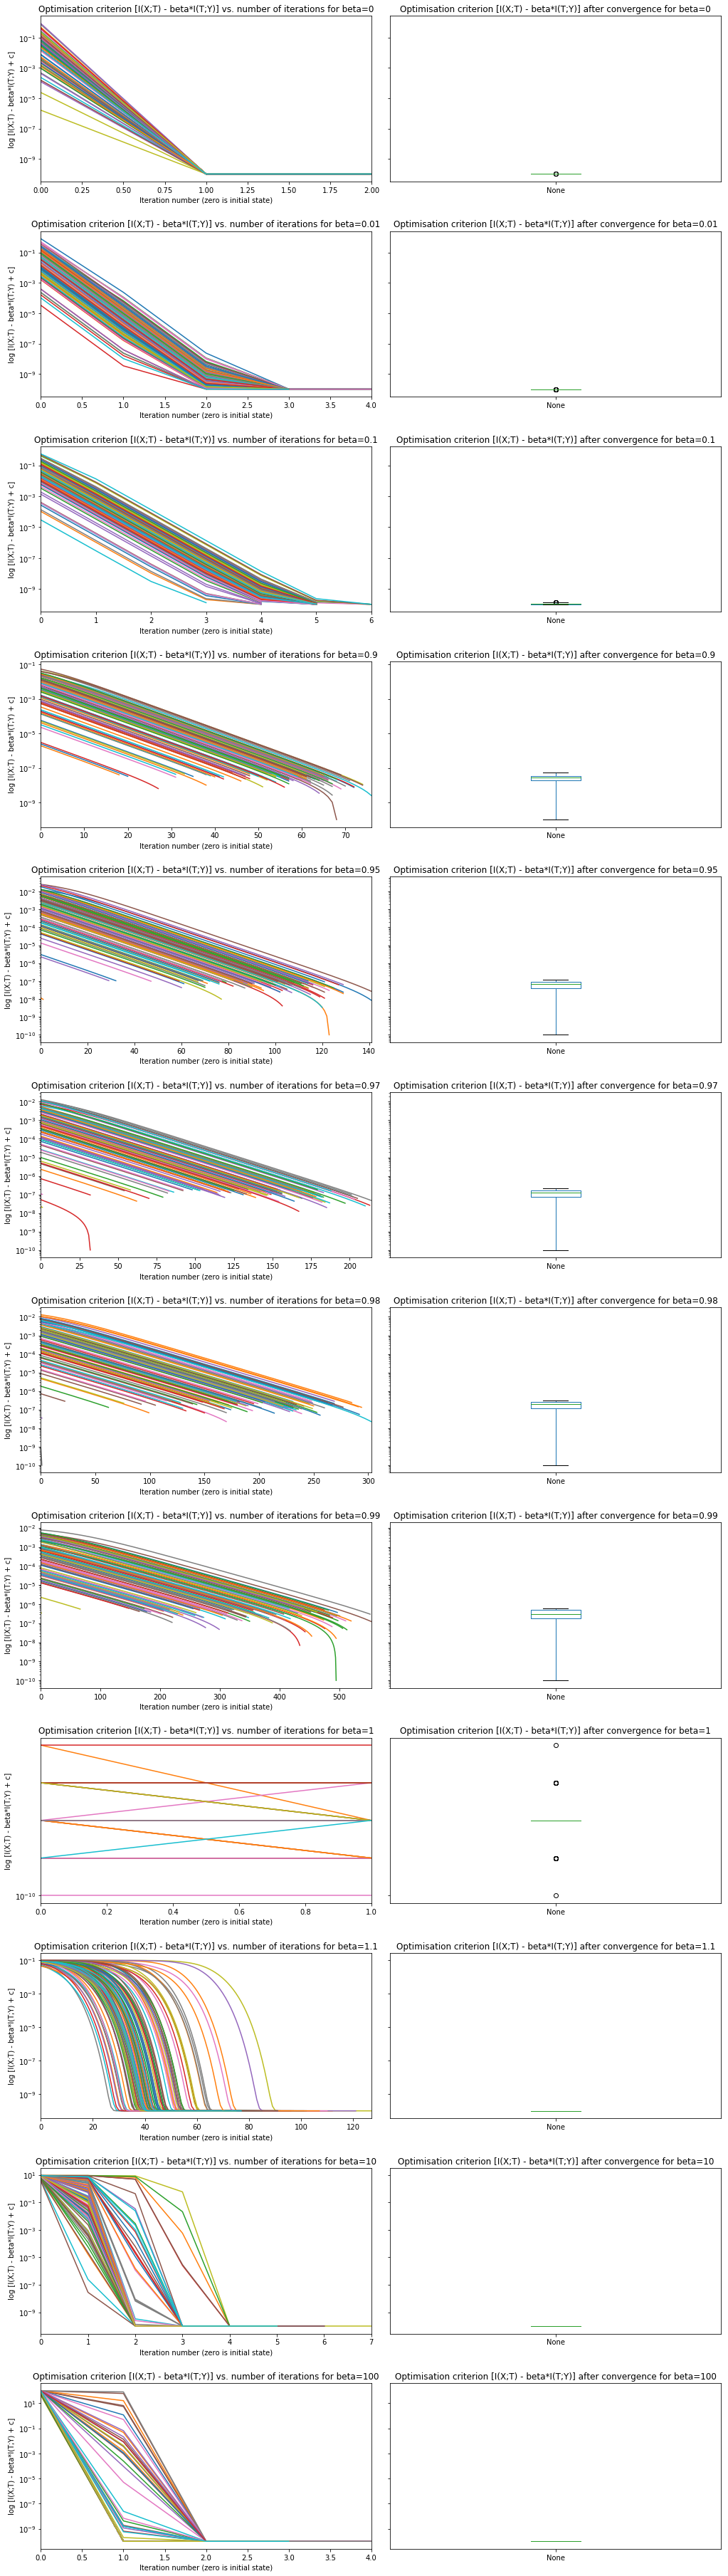

In [7]:
p_xy_joint = np.array(((0.5, 0.0),
                       (0.0, 0.5)))
np.random.seed(1)
evaluate_convergence(p_xy_joint, beta_values=(0, 0.01, 0.1, 0.9, 0.95, 0.97, 0.98, 0.99, 1, 1.1, 10, 100))

### Key observations:
1) With the exception of $\beta=1$, the optimisation criterion appears to decrease monotonically with each iteration

2) Depending on the chosen value of $\beta$ and initial state, the number of required iterations may vary between 1 and in the order of $10^2$ observations

3) With the exception of $\beta \in \left\{0, 0.01, 1.1, 10, 100 \right\}$, the IB algorithm performs local optimisation

4) For $\beta=1$, the optimisation criterion appears to increase between the initial and final state. We attribute this behaviour to numerical precision issues; we disregard this behaviour on the basis of the error being less than $10^{-9}$.

## Analysis of Mutual Information Terms after Convergence
Finally, based on the aforementioned trivial joint distribution, we plot the behaviour of the quantities $I(X;T)$, $I(T;Y)$ after convergence, in response to $\beta$. In the plots, error bars represent standard errors with respect to 20 runs.

In [8]:
def evaluate_information_tradeoff(p_xy_joint, beta_values, n_runs=20, **kwargs):
    mutual_information_xt_collected = {}
    mutual_information_ty_collected = {}

    for beta in beta_values:
        mutual_information_xt_collected[beta] = []
        mutual_information_ty_collected[beta] = []
        
        for i in range(n_runs):
            ib = IBEstimator(beta=beta, **kwargs)
            ib.train(p_xy_joint)
        
            mutual_information_xt, mutual_information_ty = compute_mutual_information_terms(p_xy_joint,
                                                                                            ib.q_tx_conditional,
                                                                                            ib.q_yt_conditional)            
            
            mutual_information_xt_collected[beta].append(mutual_information_xt)
            mutual_information_ty_collected[beta].append(mutual_information_ty)
    
    mutual_information_xt_collected = pd.DataFrame(mutual_information_xt_collected)
    mutual_information_ty_collected = pd.DataFrame(mutual_information_ty_collected)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    mutual_information_xt_collected.mean().plot(ax=axes[0],
                                                title='I(X;T) vs. beta (error bars are standard errors over n_runs={})'.format(n_runs),
                                                yerr=mutual_information_xt_collected.std() / np.sqrt(n_runs))
    mutual_information_ty_collected.mean().plot(ax=axes[1],
                                                title='I(T;Y) vs. beta (error bars are standard errors over n_runs={})'.format(n_runs),
                                                yerr=mutual_information_ty_collected.std() / np.sqrt(n_runs))
        
    axes[0].set_xlabel("beta")
    axes[0].set_ylabel("I(X;T) (bits)")
    axes[1].set_xlabel("beta")
    axes[1].set_ylabel("I(T;Y) (bits)")

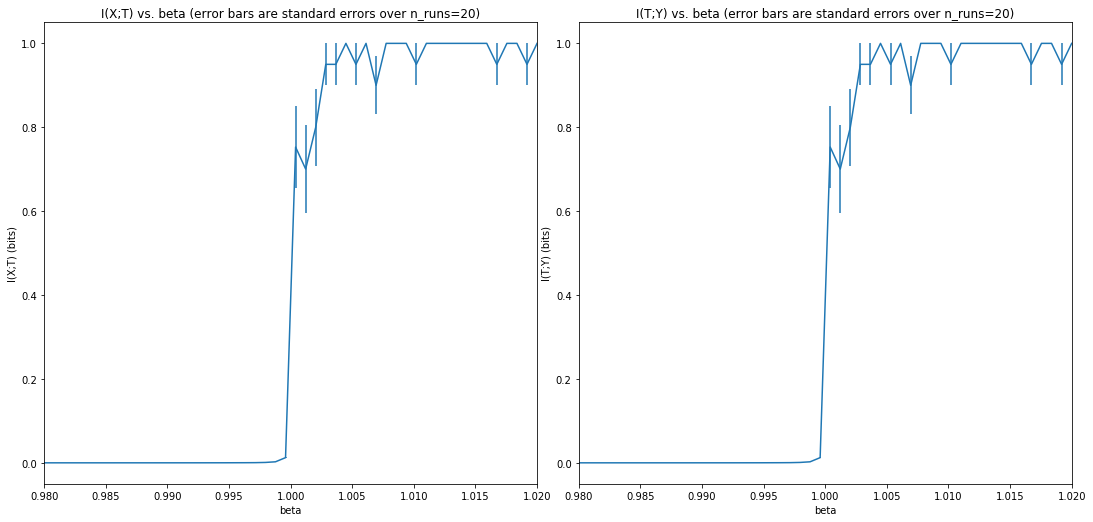

In [9]:
p_xy_joint = np.array(((0.5, 0.0),
                       (0.0, 0.5)))
np.random.seed(1)
evaluate_information_tradeoff(p_xy_joint, beta_values=np.linspace(0.98, 1.02))

### Key observations:
1) As observed, both $I(X;T)$ and $I(T;Y)$ behave identically. This observation matches expected behaviour, since $X$ and $Y$ are perfectly correlated.

2) As observed on the basis of average behaviour over 20 runs, there is a change point around $\beta \approx 1$ from $I(X;T) \approx 0$ bits to $I(X;T) \approx 1$ bits. This observation matches previously observed behaviour, with $T$ and $X$ representing uncorrelated variables for small values of $\beta$, and with $T$ and $X$ representing maximally correlated variables for large values of $\beta$.

# Experiment Set  II)
We next consider the joint distribution $P_{X, Y}$ which defines a bijection on imbalanced binary outcomes of $X$,
$$ P_{XY}(x, y) = \begin{bmatrix} 0.001 & 0 \\ 0 & 0.999 \end{bmatrix}_{x, y}$$
where $\mathcal{X} = \mathcal{Y} = \left\{1, 2 \right\}$.
## Manual Inspection of Encoding Table vs. Convergence Statistic
As was undertaken previously, we manually inspect the encoding table $Q_{T|X}^n$ versus the convergence statistic at iteration $n$, for various values of $\beta$:

In [10]:
p_xy_joint = np.array(((0.001, 0.000),
                       (0.000, 0.999)))
np.random.seed(0)
evaluate_encoding_matrix_updates(p_xy_joint, beta_values=(0, 0.1, 1, 10, 100))

---------Training with parameters beta=0, additional args={}---------
Initial state:
[[0.43418691 0.56581309]
 [0.52521691 0.47478309]]
State after iteration 1 (convergence stat. is 0.209446580744):
[[0.52512588 0.47487412]
 [0.52512588 0.47487412]]
State after iteration 2 (convergence stat. is 0.0):
[[0.52512588 0.47487412]
 [0.52512588 0.47487412]]
---------Training with parameters beta=0.1, additional args={}---------
Initial state:
[[0.39610605 0.60389395]
 [0.32917129 0.67082871]]
State after iteration 1 (convergence stat. is 0.152570041429):
[[0.33567214 0.66432786]
 [0.32923153 0.67076847]]
State after iteration 2 (convergence stat. is 0.0172596264297):
[[0.32987856 0.67012144]
 [0.32923732 0.67076268]]
State after iteration 3 (convergence stat. is 0.00174780960207):
[[0.329302  0.670698 ]
 [0.3292379 0.6707621]]
State after iteration 4 (convergence stat. is 0.000175001374598):
[[0.32924437 0.67075563]
 [0.32923796 0.67076204]]
State after iteration 5 (convergence stat. is 1.750

### Key observations:
1) As was observed previously, the encoding table $Q_{T|X}$ appears to converge, with the convigence statistic matching observed relative changes in conditional probability. We observe no unexpected convergence test behaviour. By contrast, more iterations are be required for convergence; the observed number of itertions before converge ranges between 1 and 97, the latter observed for $\beta = 10$.

## Analysis of Optimisation Criterion Behaviour
As was undertaken previously, we next consider a larger, finer-grained set of values for $\beta$ and plot the evolution of $I(X;T) - \beta I(T;Y)$ over 100 runs.

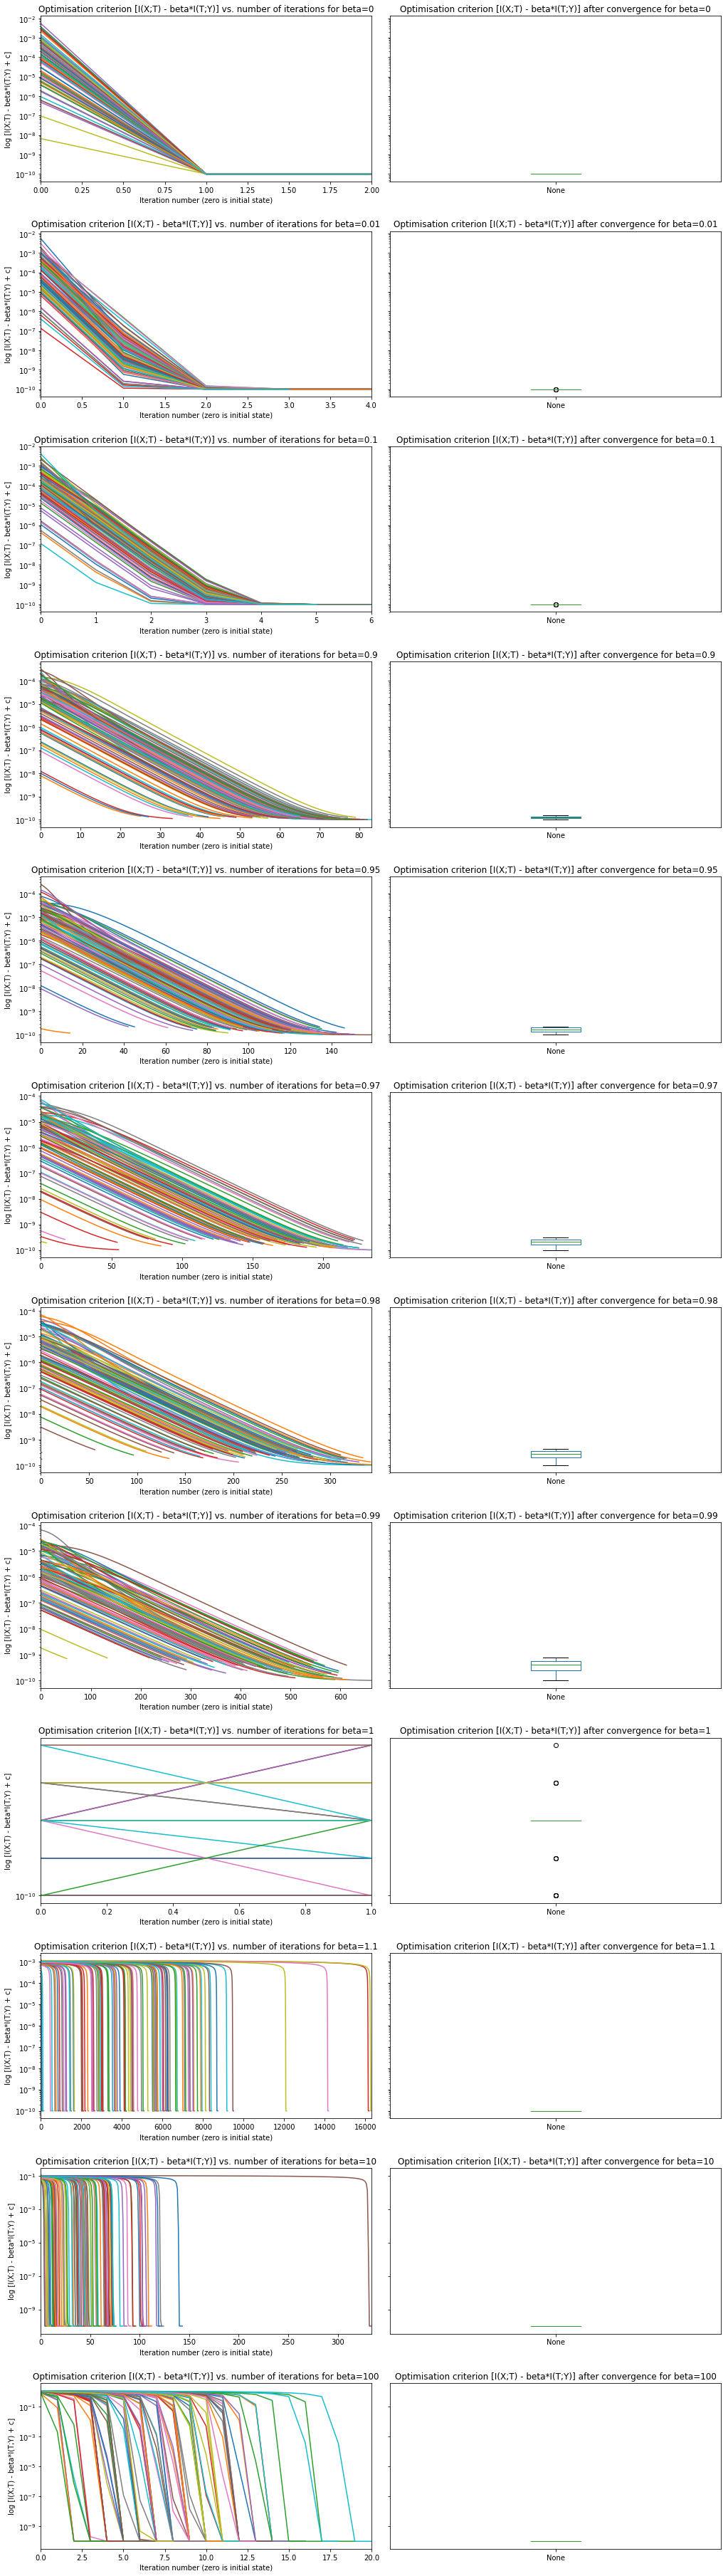

In [11]:
p_xy_joint = np.array(((0.001, 0.000),
                       (0.000, 0.999)))
np.random.seed(1)
evaluate_convergence(p_xy_joint, beta_values=(0, 0.01, 0.1, 0.9, 0.95, 0.97, 0.98, 0.99, 1, 1.1, 10, 100))

### Key observations:
1) Depending on the chosen value of $\beta$ and initial state, the number of required iterations may vary between 1 and in the order of $10^4$ observations.

2) With the exception of $\beta \in \left\{0, 0.01, 0.1, 1.1, 10, 100 \right\}$, the IB algorithm performs local optimisation.

## Analysis of Mutual Information Terms after Convergence
As was undertaken previously, we plot the behaviour of the quantities $I(X;T)$, $I(T;Y)$ after convergence, in response to $\beta$.

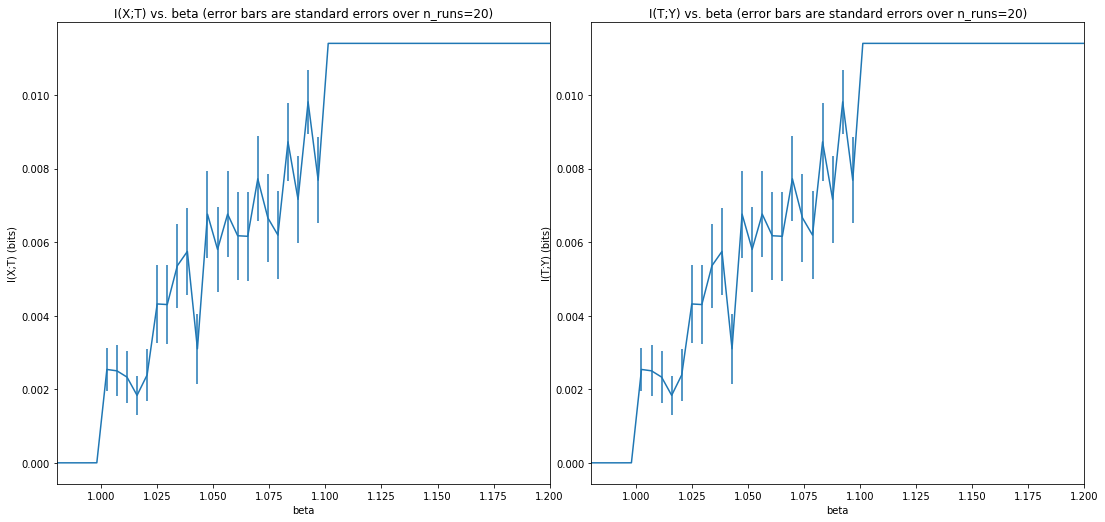

In [12]:
p_xy_joint = np.array(((0.001, 0.000),
                       (0.000, 0.999)))
np.random.seed(1)
evaluate_information_tradeoff(p_xy_joint, beta_values=np.linspace(0.98, 1.2))

### Key observations:
1) As observed, both $I(X;T)$ and $I(T;Y)$ behave identically. This observation matches expected behaviour, since $X$ and $Y$ are perfectly correlated.

2) As observed on the basis of average behaviour over 20 runs, there is a change point around $\beta \approx 1$ from $I(X;T) \approx 0$ bits to $I(X;T) \approx 0.999 \log_2 \frac{1}{0.999} + 0.001 \log_2 \frac{1}{0.001} \approx 0.0114$ bits. This observation matches previously observed behaviour, with $T$ and $X$ representing uncorrelated variables for small values of $\beta$, and with $T$ and $X$ representing maximally correlated variables for large values of $\beta$.

# Experiment Set  III)
We next consider the joint distribution $P_{X, Y}$ which defines a non-injective surjective mapping of outcomes in $X$, 
$$ P_{XY}(x, y) = \begin{bmatrix} 0.0 & 0.25 \\ 0.0 & 0.25 \\ 0.25 & 0.0 \\ 0.25 & 0.0 \end{bmatrix}_{x, y}$$
where $\mathcal{X} = \left\{1, 2, 3, 4 \right\}$, $\mathcal{Y} = \left\{1, 2 \right\}$. Note that as defined, there are outcomes $X$ which are redundant for predicting outcomes in $Y$. **In the following experiments involving this joint distribution, we execute the IB algorithm based on $\mathcal{X} = \mathcal{T} = \left\{1, 2, 3, 4 \right\}$**.

## Manual Inspection of Encoding Table vs. Convergence Statistic
As was undertaken previously, we manually inspect the encoding table $Q_{T|X}^n$ versus the convergence statistic at iteration $n$, for various values of $\beta$.

In [13]:
p_xy_joint = np.array(((0.0, 0.25),
                       (0.0, 0.25),
                       (0.25, 0.0),
                       (0.25, 0.0)))
np.random.seed(0)
evaluate_encoding_matrix_updates(p_xy_joint, beta_values=(0, 0.1, 1, 10, 100))

---------Training with parameters beta=0, additional args={}---------
Initial state:
[[0.2275677  0.29655611 0.24993822 0.22593797]
 [0.1766031  0.26924493 0.18241092 0.37174105]
 [0.36123028 0.14373357 0.29677919 0.19825697]
 [0.34389291 0.56035414 0.04300507 0.05274788]]
State after iteration 1 (convergence stat. is 3.48861834366):
[[0.2773235  0.31747218 0.19303335 0.21217097]
 [0.2773235  0.31747218 0.19303335 0.21217097]
 [0.2773235  0.31747218 0.19303335 0.21217097]
 [0.2773235  0.31747218 0.19303335 0.21217097]]
State after iteration 2 (convergence stat. is 0.0):
[[0.2773235  0.31747218 0.19303335 0.21217097]
 [0.2773235  0.31747218 0.19303335 0.21217097]
 [0.2773235  0.31747218 0.19303335 0.21217097]
 [0.2773235  0.31747218 0.19303335 0.21217097]]
---------Training with parameters beta=0.1, additional args={}---------
Initial state:
[[0.0080841  0.33291382 0.31113736 0.34786472]
 [0.32406883 0.26464084 0.15281859 0.25847173]
 [0.0640631  0.34661191 0.07764701 0.51167798]
 [0.26

### Key observations:
1) As was observed previously, the encoding table $Q_{T|X}$ appears to converge, with the convigence statistic matching observed relative changes in conditional probability. We observe no unexpected convergence test behaviour. The algorithm converges with 1 and 5 iterations.

2) For relatively large values of $\beta$, the resultant $Q_{T|X}$ after convergence is approximately a bijection: We note that the majority of (marginal) probability mass in $P_T$ is associated with two possible outcomes in $T$. Thus, the encoding reflects the redundancy of outcomes in $X$ for predicting outcomes in $Y$.

6) Minor observation: For $\beta=1$, $Q_{T|X}$ after convergence is *not* equivalent to the initial state $Q^1_{T|X}$. With $X$ and $Y$ not perfectly correlated, we do not have $I(X;T) = I(T;Y)$ for all $Q_{T|X}$. It follows that we should not expect the same behaviour as observed in previous experiments.

## Analysis of Optimisation Criterion Behaviour
As was undertaken previously, we next consider a larger, finer-grained set of values for $\beta$ and plot the evolution of $I(X;T) - \beta I(T;Y)$ over 100 runs.

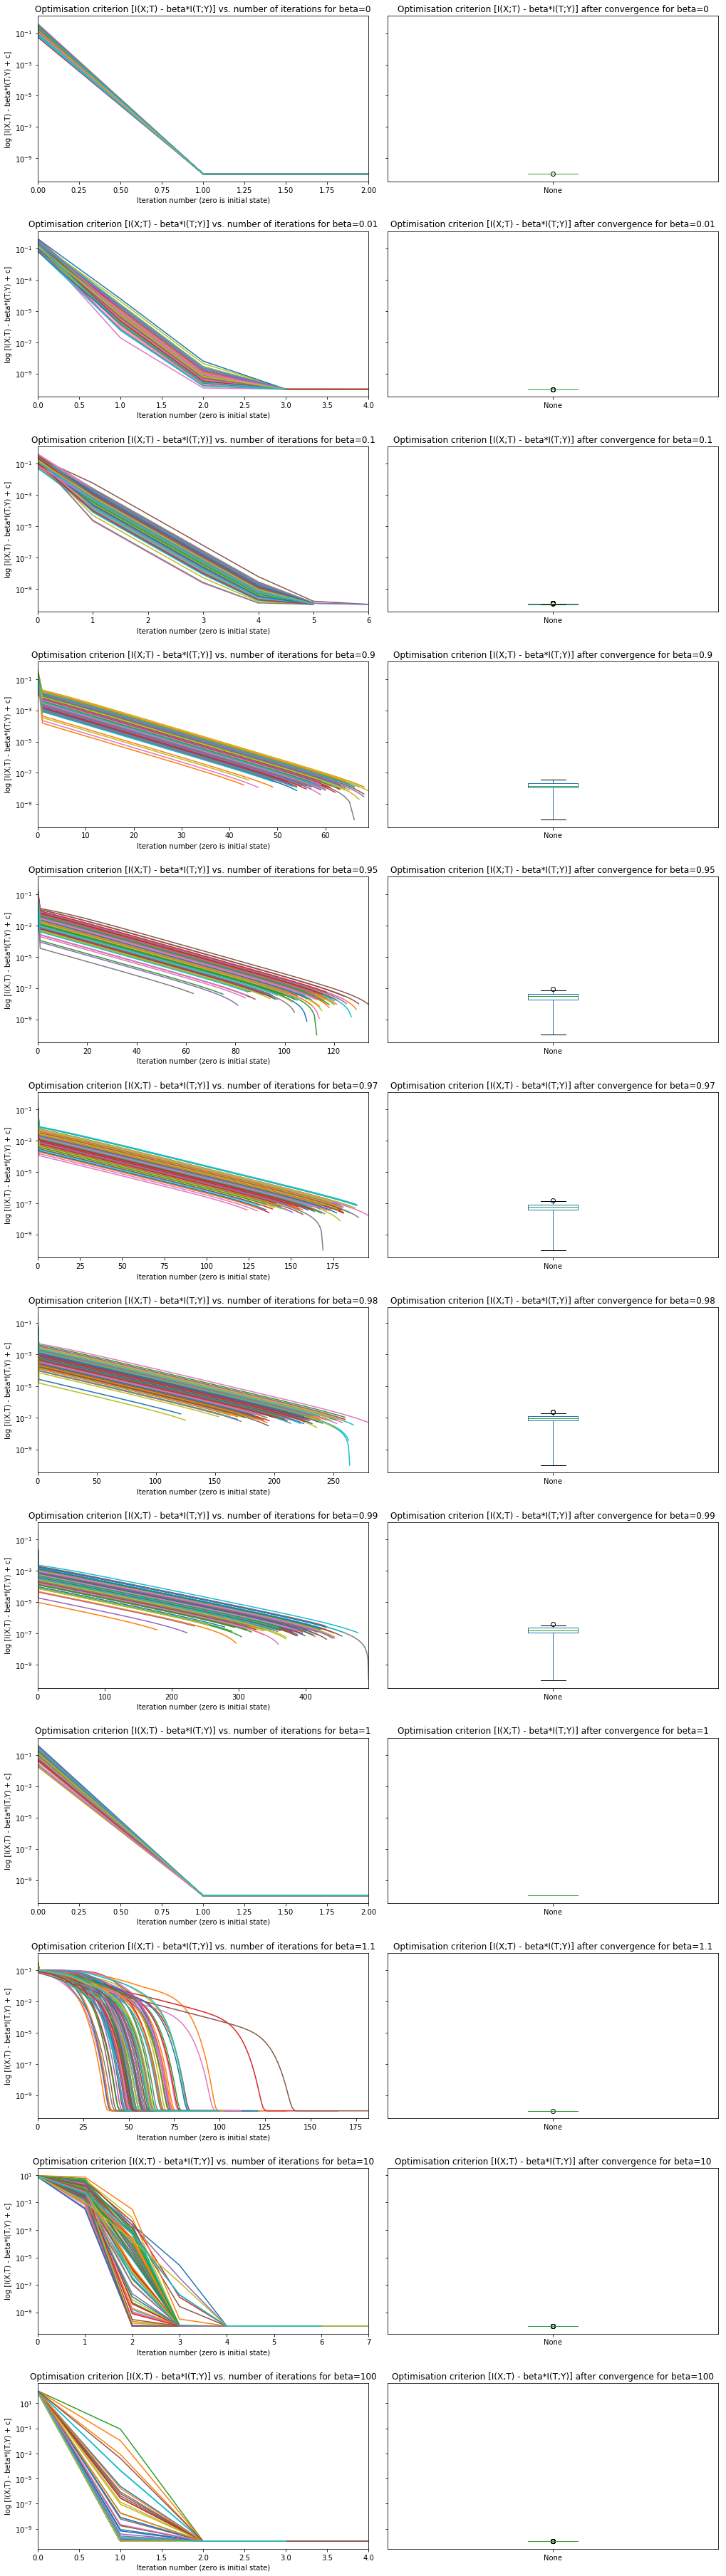

In [14]:
p_xy_joint = np.array(((0.0, 0.25),
                       (0.0, 0.25),
                       (0.25, 0.0),
                       (0.25, 0.0)))
np.random.seed(0)
evaluate_convergence(p_xy_joint, beta_values=(0, 0.01, 0.1, 0.9, 0.95, 0.97, 0.98, 0.99, 1, 1.1, 10, 100))

### Key observations:
1) Depending on the chosen value of $\beta$ and initial state, the number of required iterations may vary between 1 and in the order of $10^2$ observations.

2) With the exception of $\beta \in \left\{0, 0.01, 1.0, 1.1, 10, 100 \right\}$, the IB algorithm performs local optimisation.

3) In common with our observations in the preceding experiment, the optimisation criterion decreases monotonically for $\beta=1$.

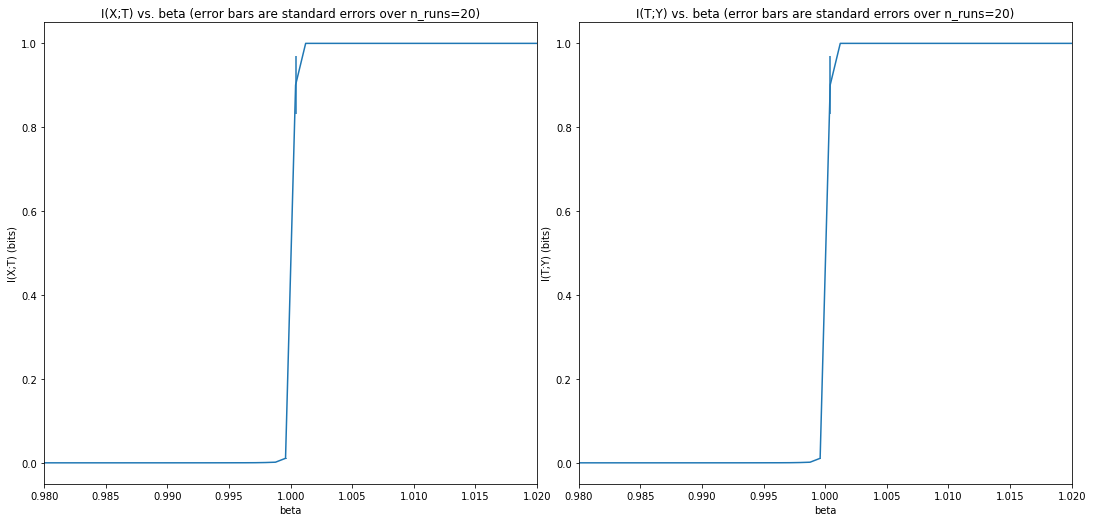

In [15]:
p_xy_joint = np.array(((0.0, 0.25),
                       (0.0, 0.25),
                       (0.25, 0.0),
                       (0.25, 0.0)))
np.random.seed(0)
evaluate_information_tradeoff(p_xy_joint, beta_values=np.linspace(0.98, 1.02))

### Key observations:
1) As observed, both $I(X;T)$ and $I(T;Y)$ behave similarly. This observation initially appears counterintuitive, since $X$ and $Y$ are not perfectly correlated. However, we note that an encoding $Q_{T|X}$ such that $I(X;T) = I(T;Y) = 1$  bits is sufficient for maximising $I(T;Y)$. Thus, according to our optimisation ciriterion we would expect $I(X;T)$ to attain a maximal value of 1 bit.


2) As observed on the basis of average behaviour over 20 runs, there is a change point around $\beta \approx 1$ from $I(X;T) \approx 0$ bits to $I(X;T) \approx 1$ bits. This observation matches previously observed behaviour, with $T$ and $X$ representing uncorrelated variables for small values of $\beta$, and with $T$ and $X$ representing maximally correlated variables for large values of $\beta$.

# Evaluation Based on Synthetic Data
To conclude the analysis undertaken in this notebook, we evaluate the IB algorithm against synthetic data. In particular, we explore the algorithm's reconstruction $Q_{Y|X}$ of the given conditional distribution $P_{Y|X}$, with $Q_{Y|X}$ defined as
$$ Q_{Y|X}(y,x) = \sum_{t} Q_{Y|T}(y,t) Q_{T|X}(t,x)$$
where $Q_{T|X}$ and $Q_{Y|T}$ are the encoding and decoding tables obtained using the IB algorithm, respectively. For the purpose of this analysis, we consider the binary random variable $Y$ with outcomes $\mathcal{Y} = \left\{0, 1 \right\}$. We specify the joint distribution $P_{XY}$ as follows:

1) Sample 20 uniformly distributed random variates from the two-dimensional point set $[-1, 1)^2$. We denote this sample with the set $\mathcal{S}$.

2) Construct the sample space of $X$ by defining $100^2$ points aligned in a cartesian grid within $[-1, 1)^2$. We denote the sample space with the set $\mathcal{X}$.

3) Assign $P_{Y|X}(y, x) = \frac{1}{C} [y \, \text{KDE}(x, \mathcal{S}) + (1-y) \, (1 -\text{KDE}(x, \mathcal{S}))]$, where $\text{KDE}(x, \mathcal{S})$ is the kernel density estimate at point $x$ that we obtain based on the sample $\mathcal{S}$ and where $C$ is a normalisation constant set so that $\max_{x \in \mathcal{X}} P_{Y=1|X}(x) = 1$.

4) Assign $P_{XY}(x, y) = P_{Y|X}(y, x) P_X(x)$, where we consider the uniform distribution $P_X$.

In the following, we display contour plots of $P_{Y=1|X}$ and $Q_{Y=1|X}$, in addition to tabulated probability assignments in $Q_{T|X}$ and $Q_{Y|T}$. Because the sample space $\mathcal{X}$ is too large to display in its entirety, we tabulate $Q_{T|X}$ for a random subset of the sample space $\mathcal{X}$ only.

In addition, to quantify the fidelity of the reconstruction $Q_{Y|X}$, we compute the Kullback-Leibler divergence [2] $\text{KL}(P_{XY} \| Q_{XY})$, with $Q_{XY}$ defined as $$Q_{XY}(x,y) = Q_{Y|X}(y,x) P_X(x).$$

In [41]:
def evaluate_against_distribution(random_seed=1, n_random_samples=20, n_clusters=5, beta=10):
    # Generate samples from which we construct an exemplary probability distribution based on KDE
    np.random.seed(random_seed)
    random_samples = np.random.uniform(low=-1, high=1, size=(n_random_samples, 2))
    kde = scipy.stats.gaussian_kde(random_samples.T)

    # Construct sample space for random variable X
    dim_range = np.linspace(-1, 1, 100)
    x_samplespace = np.array(list((itertools.product(dim_range, dim_range))))

    # Assign equal probabilities to outcomes in X
    p_x = np.ones(x_samplespace.shape[0])
    p_x /= np.sum(p_x)

    # Conditional probability of Y=1 given X=x is K*KDE(x), where KDE(x) is the estimated probability density
    # at point x and where K is a normalisation constant such that KDE(x) is 1 at its maximum
    p_yx_conditional = np.zeros((p_x.shape[0], 2))
    p_yx_conditional[:, 1] = kde(x_samplespace.T)
    p_yx_conditional[:, 1] /= np.max(p_yx_conditional[:, 1])
    p_yx_conditional[:, 0] = 1 - p_yx_conditional[:, 1]

    p_xy_joint = p_yx_conditional * np.atleast_2d(p_x).T

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8), sharey='row')
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.3)

    def plot_heat_map_with_contour(x0, x1, y, ax, title):
        scatter = ax.scatter(x0, x1, c=y, marker=',', vmin=0, vmax=1)
        contour = ax.tricontour(x0, x1, y, colors='k', levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        ax.clabel(contour, inline=1, fontsize=10)
        ax.grid(True)
        ax.set_xlim((-1, 1))
        ax.set_ylim((-1, 1))
        ax.set_title(title)
        ax.set_xlabel('x_1')
        ax.set_ylabel('x_2')

        return scatter

    # Plot heat map of P(Y=1|X=x)
    plot_heat_map_with_contour(x_samplespace[:, 0], x_samplespace[:, 1], p_yx_conditional[:, 1], axes[0],
                               title='Original distribution P(Y=1|X=x)')

    # Apply information bottleneck
    ib = IBEstimator(n_clusters=n_clusters, beta=beta, diagnostic_mode=False)
    ib.train(p_xy_joint)

    # Plot heat map of Q(Y=1|X=x), where Q is the estimated distribution
    # that we obtain based on the information bottleneck
    p_yx_conditional_estimated = np.matmul(ib.q_tx_conditional, ib.q_yt_conditional)
    scatter = plot_heat_map_with_contour(x_samplespace[:, 0], x_samplespace[:, 1],
                                         p_yx_conditional_estimated[:, 1], axes[1],
                                         title='Reconstructed distribution Q(Y=1|X=x)')

    fig.colorbar(scatter, ax=axes.ravel().tolist())
    plt.show()        
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    
    def plot_conditional_distribution(conditional_distribution, ax, title, xlabel, ylabel):
        ax.imshow(conditional_distribution)
        for i in range(conditional_distribution.shape[0]):
            for j in range(conditional_distribution.shape[1]):
                text = ax.text(j, i, '{:.3f}'.format(conditional_distribution[i, j]),
                               ha='center', va='center')    
        ax.set_yticks(np.arange(0, conditional_distribution.shape[0]))
        ax.set_xticks(np.arange(0, conditional_distribution.shape[1]))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
    
    random_idx = np.random.choice(ib.q_tx_conditional.shape[0], ib.q_yt_conditional.shape[0])
    plot_conditional_distribution(ib.q_tx_conditional[random_idx], axes[0],
                                  'Extract from encoding table Q(T|X) based on random subset of outcomes in X',
                                  'Distinct outcome in T', 'Distinct outcome in X')
    plot_conditional_distribution(ib.q_yt_conditional, axes[1],
                                  'Decoding table Q(Y|T)',
                                  'Distinct outcome in Y', 'Distinct outcome in T')

    plt.show()

    print('Kullback-Leibler divergence from estimated joint distribution Q(X,Y) to original joint distribition P(X,Y) is {:.4} bits'.format(
        drv.divergence_kullbackleibler_pmf(np.ravel(p_xy_joint),
                                           np.ravel(p_yx_conditional_estimated * np.atleast_2d(p_x).T))))
    
    return ib

Based on $K=4$ codewords (i.e. 4 possible outcomes of $T$), let us first execute the IB algorithm with $\beta=3.8$:

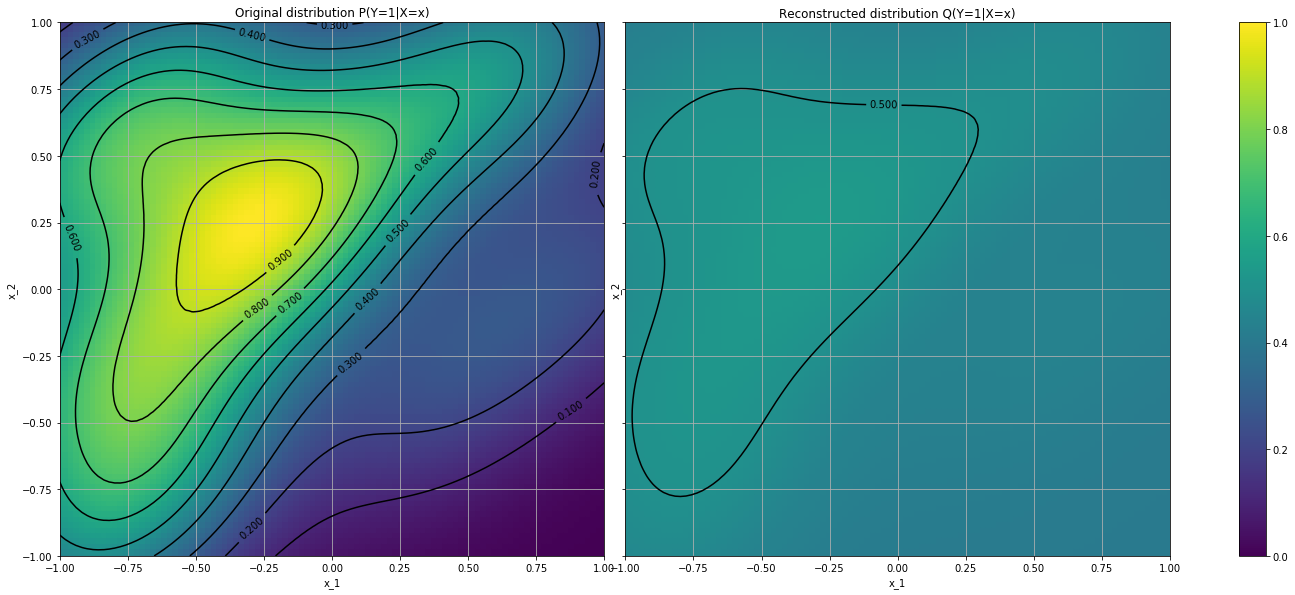

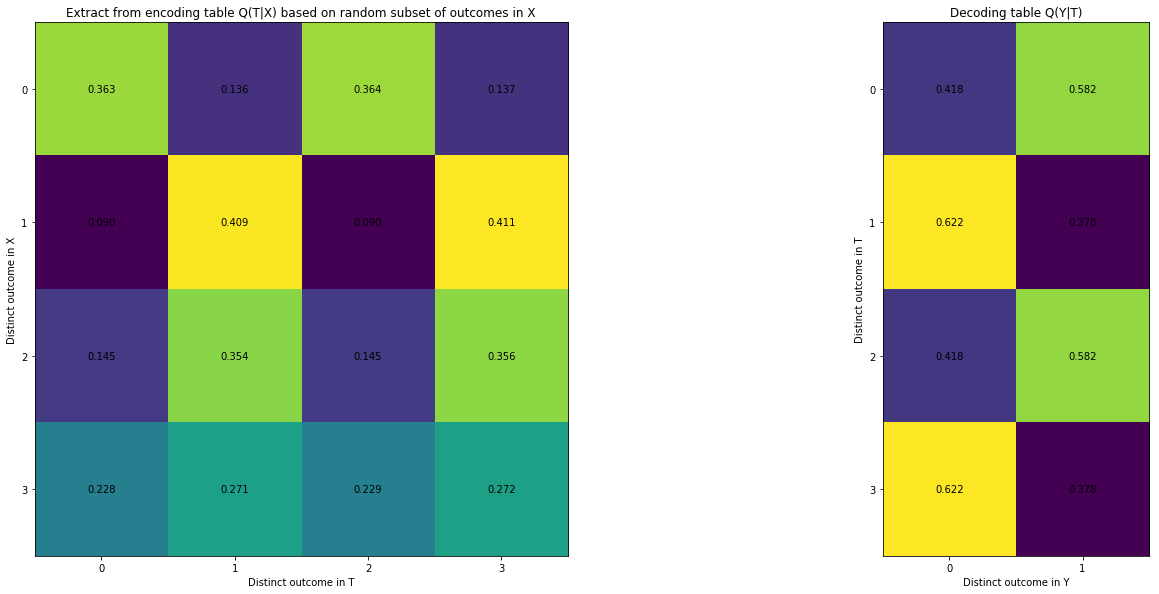

Kullback-Leibler divergence from estimated joint distribution Q(X,Y) to original joint distribition P(X,Y) is 0.1795 bits


In [42]:
ib = evaluate_against_distribution(n_clusters=4, beta=3.8)

As observed, with only the 0.5 contour visible in its rough shape, the reconstruction $Q_{Y|X}$ appears to be a highly approximated representation of the original distribution $P_{Y|X}$. Inspection of the decoding table $Q_{Y|T}$ confirms there are 2 pairs of probability assignments with identical values, thus the effective utilised number of codewords is 2, i.e. less than the number of possible codewords.

Retaining $K=4$ codewords (i.e. 4 possible outcomes of $T$), we next increase $\beta$ to $9.0$:

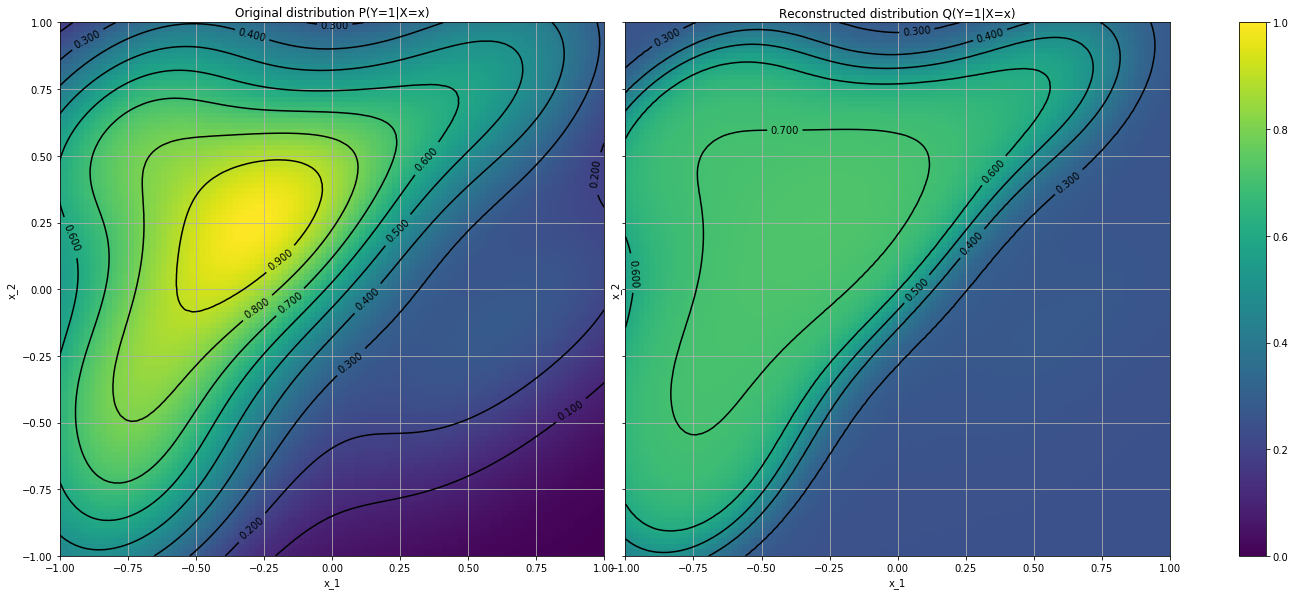

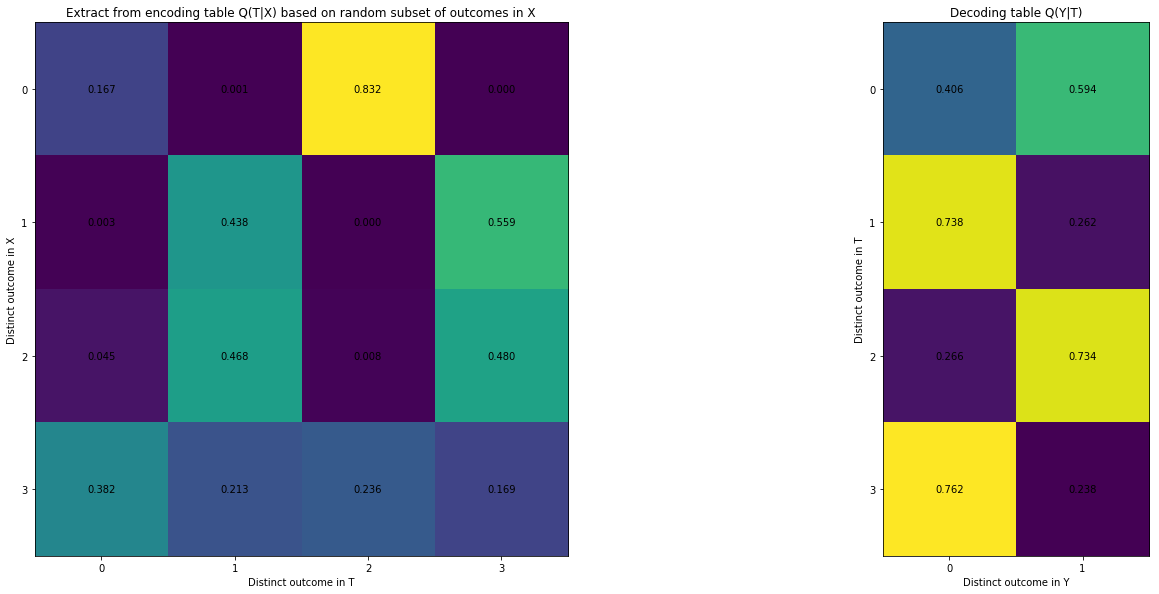

Kullback-Leibler divergence from estimated joint distribution Q(X,Y) to original joint distribition P(X,Y) is 0.04735 bits


In [43]:
ib = evaluate_against_distribution(n_clusters=4, beta=9.0)

With more contour lines visible and their shape more accurate compared to the original distribution $P_{Y|X}$, increasing $\beta$ appears to have the expected effect of yielding a more accurate reconstruction $Q_{Y|X}$. Inspection of the decoding table $Q_{Y|T}$ confirms that the effective utilised number of codewords has increased to 3.

Retaining $K=4$ codewords (i.e. 4 possible outcomes of $T$), we further increase $\beta$ to $14.0$:

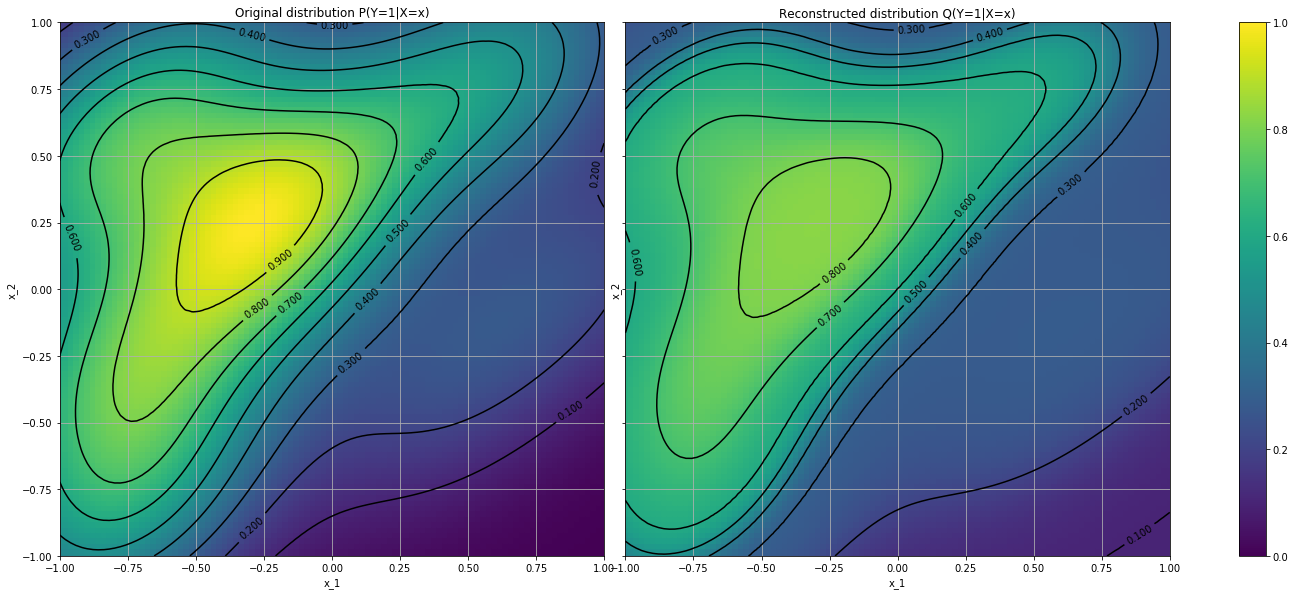

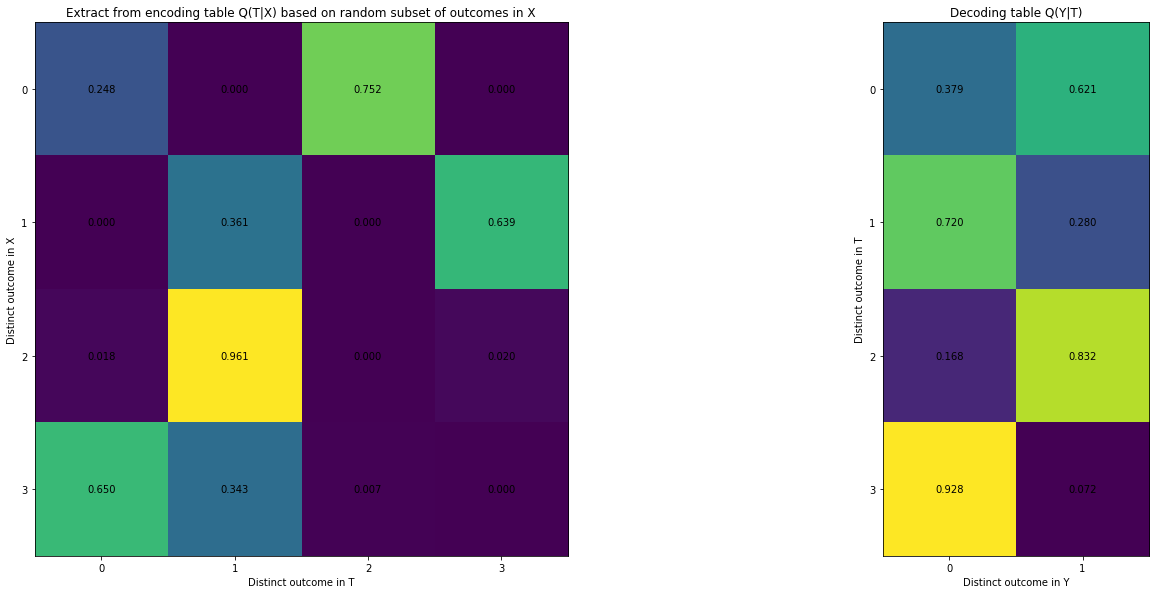

Kullback-Leibler divergence from estimated joint distribution Q(X,Y) to original joint distribition P(X,Y) is 0.01945 bits


In [57]:
ib = evaluate_against_distribution(n_clusters=4, beta=14)

As observed, the reconstruction $Q_{Y|X}$ appears to be a yet more accurate representation of the original distribution $P_{Y|X}$. (Inspection of KL divergence between $P_{XY}$ and $Q_{XY}$ corroborates this evidence.) Inspecting the decoding table $Q_{Y|T}$, we note that the effective utilised number of codewords has increased to 4.

Retaining $K=4$ codewords (i.e. 4 possible outcomes of $T$), we further increase $\beta$ to $30.0$:

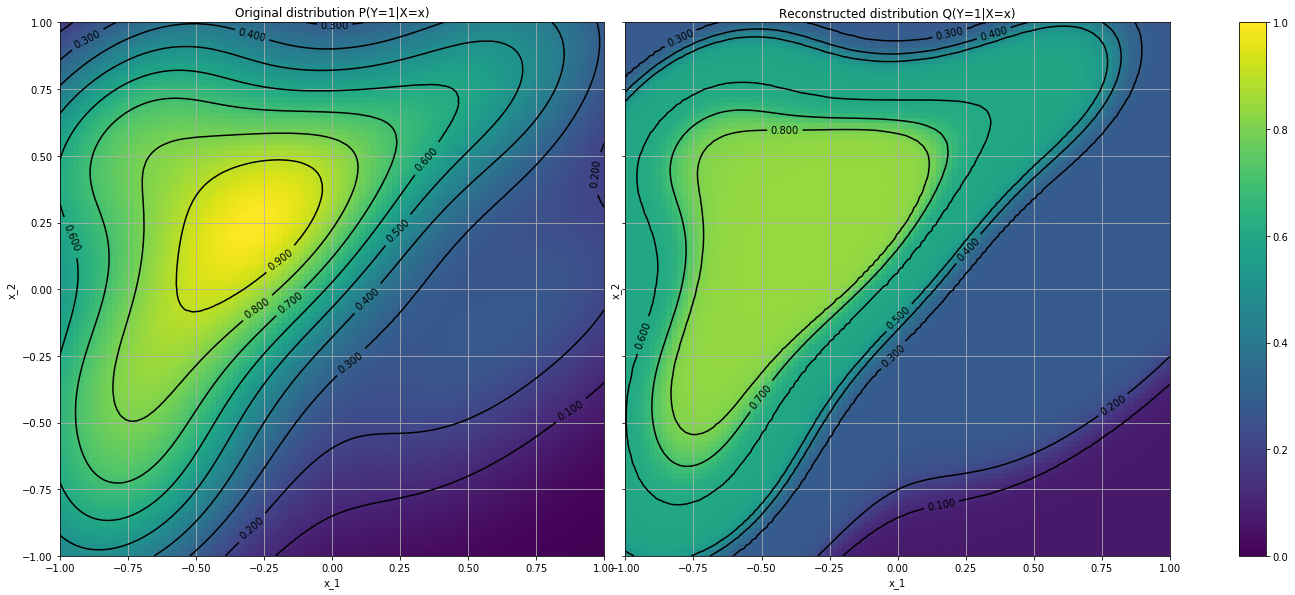

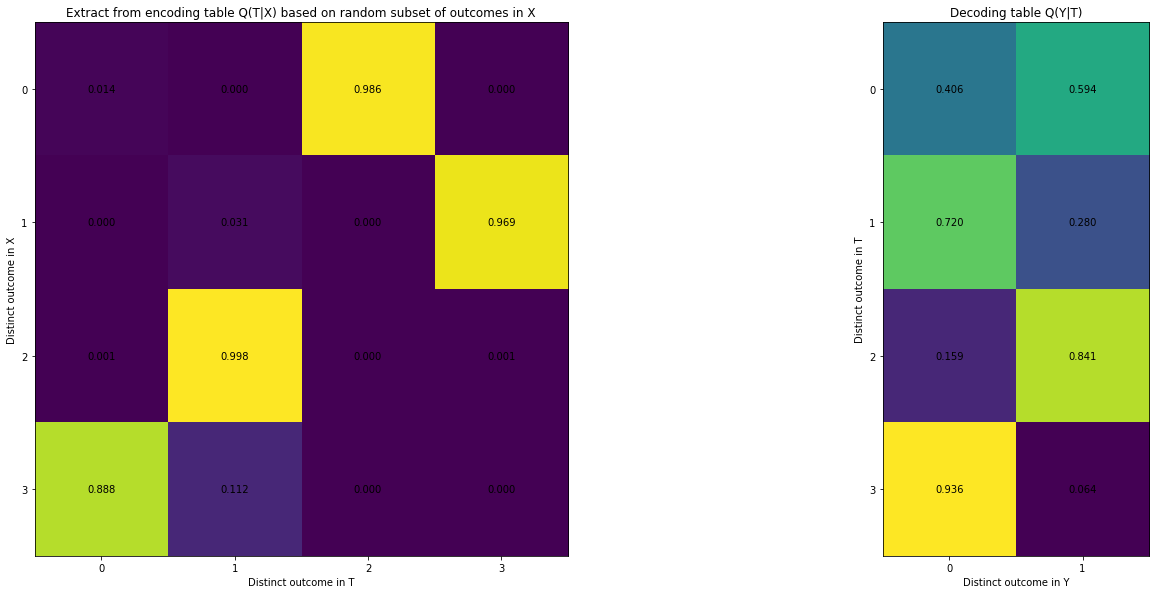

Kullback-Leibler divergence from estimated joint distribution Q(X,Y) to original joint distribition P(X,Y) is 0.0124 bits


In [58]:
ib = evaluate_against_distribution(n_clusters=4, beta=30)

As observed, KL divergence is lower for $\beta=30$ compared to $\beta=14$, suggesting that the reconstruction $Q_{Y|X}$ is a more accurate representation of the original distribution $P_{Y|X}$. However, we observe that the contour lines in the reconstruction are noticably less smooth, suggesting that the codeword assignment is harder for larger values of $\beta$. Inspection of the encoding table $Q_{T|X}$ indeed suggests a harder codeword assignment.

Although such observed behaviour appears to be counterintuitive, we explain it as follows: For large values of $\beta$, the term $I(T:Y)$ becomes increasingly dominant when minimising $\mathcal{L}[Q_{T|X}]$, having the effect of promoting outcomes in $T$ which are highly informative about $Y$. At the same time, since the term $I(T;Y)$ becomes increasingly dominant, we admit increasingly large values of $I(X;T)$. We believe the observed harder codeword assignment is a side-effect of promoting effective representations $T$ for predicting outcomes in $Y$, while admitting increasing amounts of correlation between $X$ and $T$.

Finally, retaining $K=4$ codewords (i.e. 4 possible outcomes of $T$), we further increase $\beta$ to $128.0$:

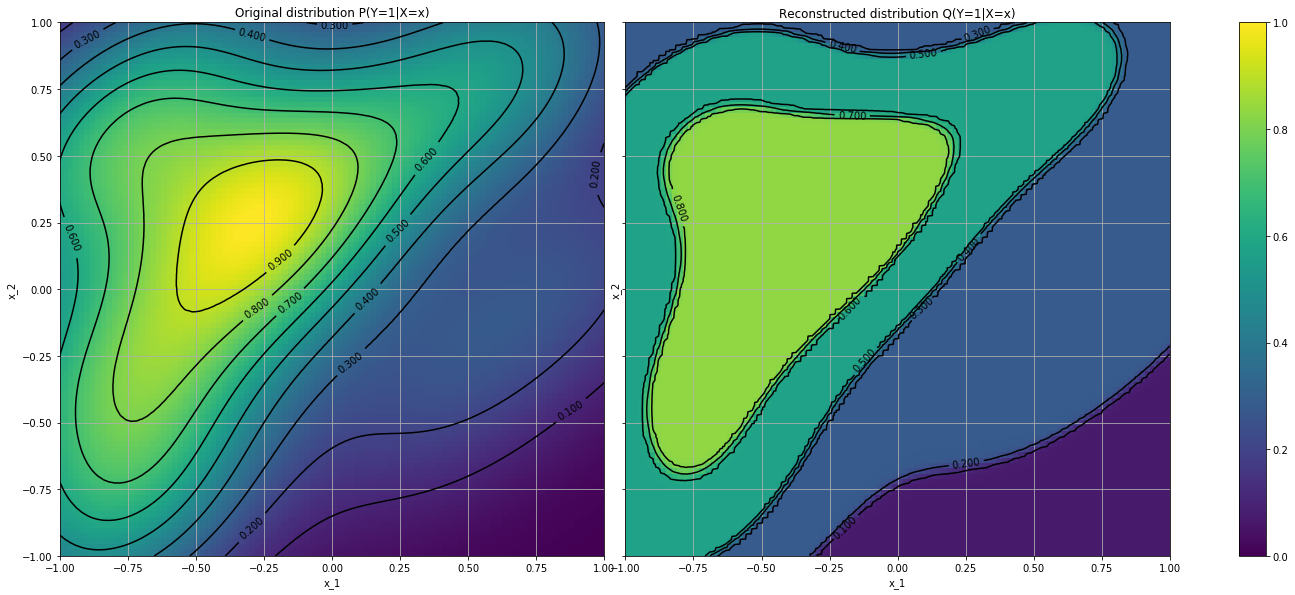

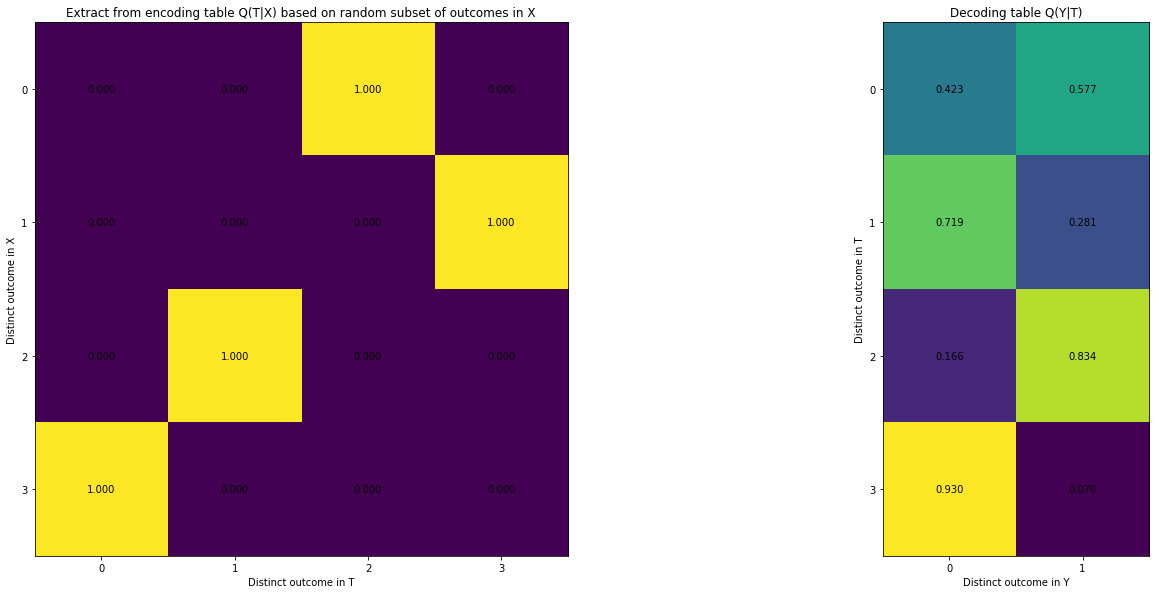

Kullback-Leibler divergence from estimated joint distribution Q(X,Y) to original joint distribition P(X,Y) is 0.01946 bits


In [59]:
ib = evaluate_against_distribution(n_clusters=4, beta=128)

Using $\beta=128$ the contour lines in the reconstuction $Q_{Y|X}$ appear even less smooth compared to results using $\beta=30$. Inspection of the encoding table $Q_{T|X}$ reveals maximally hard codeword assignment for the subset of considered outcomes in $X$. Indeed, the fact that the contour plot of the reconstructed distribution $Q_{Y|X}$ displays approximately 4 shaded regions with sharp transitions, suggests hard codeword assignment for the large majority of the sample space of $X$. Finally, we note that the IB algorithm minimises $\mathcal{L}[Q_{T|X}]$, rather than minimise $\text{KL}(P_{XY} \| Q_{XY})$. We attribute the observation that KL divergence from $Q_{Y|X}$ to $P_{Y|X}$ is higher for $\beta=128$ compared to $\beta=30$ to the different interpretation of these loss functions [2].

# Conclusion
This notebook has evaluated a prototype implementation of the discrete IB algorithm proposed by Tiby et al. [1]. Toy examples and synthetic data provide evidence that the implementation is correct. With a view to developing a production-grade version of the algorithm, it may be useful to evaluate the algorithm's efficiency, stability and robustness, using additional, real-world datasets and while considering extreme values for the parameter $\beta$.